In [38]:
import cv2
import numpy as np
import cv2 as cv
import glob
import time
from tqdm import tqdm
from copy import deepcopy
import scipy.optimize as sopt
from klampt.math import se3,so3
from itertools import combinations
import pickle
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import open3d as o3d
import pandas as pd
from create_point_cloud import load_whole_point_cloud
import scipy


In [2]:
# Copyright (c) OpenMMLab. All rights reserved.
from collections import deque
from queue import Queue
from threading import Event, Lock, Thread

import cv2

from mmpose.apis import (get_track_id, inference_top_down_pose_model,
                         init_pose_model, vis_pose_result)
from mmpose.core import apply_bugeye_effect, apply_sunglasses_effect
from mmpose.utils import StopWatch

try:
    from mmdet.apis import inference_detector, init_detector
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False

try:
    import psutil
    psutil_proc = psutil.Process()
except (ImportError, ModuleNotFoundError):
    psutil_proc = None

In [3]:
def get_aligned_dataset(dataset_folder,master_camera = 'cam_torso_depth'):
    cam_folders = sorted(glob(dataset_folder+'/*'))

    dataset_dict = {}

    for cam_folder in cam_folders:
        cam_name = cam_folder.split('/')[-1]

        color_dataset = sorted(glob('{}/color/*'.format(cam_folder)))
        depth_dataset = sorted(glob('{}/depth/*'.format(cam_folder)))

        dataset_dict.update({'{}_depth'.format(cam_name):depth_dataset,'{}_color'.format(cam_name):color_dataset})
        
        dataframes = {}
        for i in dataset_dict.keys():
            df = pd.DataFrame({'frame':dataset_dict[i]})
            timestamps = df.frame.str.split('_',expand = True).iloc[:,-1].str.split('.',expand = True).iloc[:,0].astype(float)
            df['timestamps'] = timestamps
            df.columns = [i,'timestamps']
            dataframes.update({i:df})
            
    dict_keys = list(dataset_dict.keys())

    original_df = dataframes[master_camera]
    for i in dict_keys:
        if(i != master_camera):
            original_df[i] = np.nan

    sorted_df = original_df.sort_values(by = 'timestamps')
    filled_df = sorted_df.fillna(method= 'ffill',limit = 11)

    for i in tqdm(range(original_df.shape[0])):
        timestamp = original_df.timestamps[i]
        for j in dict_keys:
            if(j != master_camera):
                td = np.min(np.abs(dataframes[j].timestamps-timestamp))/1000000000
                index = np.argmin(np.abs(dataframes[j].timestamps-timestamp))
                if(td < 1/60):
                    original_df.loc[i,j] = dataframes[j].loc[index,j]

    original_df.shape

    clean_df = original_df.dropna()
    clean_df.reset_index(drop = True, inplace = True)
    return clean_df

In [4]:
def infer_pose(frame, mmdet_results,det_score_thr = 0.3):

    pose_results_list = []
    for model_info, pose_history in zip(pose_model_list,
                                        pose_history_list):
        model_name = model_info['name']
        pose_model = model_info['model']
        cat_ids = model_info['cat_ids']
        pose_results_last = pose_history['pose_results_last']
        next_id = pose_history['next_id']

        # process mmdet results
        det_results = process_mmdet_results(
            mmdet_results,
            class_names=det_model.CLASSES,
            cat_ids=cat_ids)

        # inference pose model
        dataset_name = pose_model.cfg.data['test']['type']
        pose_results, _ = inference_top_down_pose_model(
            pose_model,
            frame,
            det_results,
            bbox_thr=det_score_thr,
            format='xyxy',
            dataset=dataset_name)

        pose_results, next_id = get_track_id(
            pose_results,
            pose_results_last,
            next_id,
            use_oks=False,
            tracking_thr=0.3,
            use_one_euro=True,
            fps=None)

        pose_results_list.append(pose_results)

        # update pose history
        pose_history['pose_results_last'] = pose_results
        pose_history['next_id'] = next_id
    return pose_results_list
        

In [5]:
def inference_detection(frame):
    # inference detection
    mmdet_results = inference_detector(det_model, frame)
    return mmdet_results

In [6]:
def process_mmdet_results(mmdet_results, class_names=None, cat_ids=1):
    """Process mmdet results to mmpose input format.

    Args:
        mmdet_results: raw output of mmdet model
        class_names: class names of mmdet model
        cat_ids (int or List[int]): category id list that will be preserved
    Returns:
        List[Dict]: detection results for mmpose input
    """
    if isinstance(mmdet_results, tuple):
        mmdet_results = mmdet_results[0]

    if isinstance(class_names, str):
        class_names = (class_names, )

    if not isinstance(cat_ids, (list, tuple)):
        cat_ids = [cat_ids]

    # only keep bboxes of interested classes
    bbox_results = [mmdet_results[i - 1] for i in cat_ids]
    bboxes = np.vstack(bbox_results)

    # get textual labels of classes
    labels = np.concatenate([
        np.full(bbox.shape[0], i - 1, dtype=np.int32)
        for i, bbox in zip(cat_ids, bbox_results)
    ])
    if class_names is None:
        labels = [f'class: {i}' for i in labels]
    else:
        labels = [class_names[i] for i in labels]

    det_results = []
    for bbox, label in zip(bboxes, labels):
        det_result = dict(bbox=bbox, label=label)
        det_results.append(det_result)
    return det_results

In [81]:
def find_hand_center(hand_points,images_df,cam_side = 'right',trans_dir = './Calibration/data/extrinsics'):
    # create grayscale image with white circle (255) on black background (0)
    mask = np.zeros(shape = frame.shape[:2],dtype = np.uint8)
    hand_points = hand_points[hand_points[:,2] > 0.1]
    for point in hand_points:
        cv2.circle(mask,(int(point[0]),int(point[1])),3,255,-1)
    coordy,coordx = np.where(mask>0)
    points = np.ravel_multi_index((coordy,coordx),frame.shape[:2])

    color = images_df.loc[index,'cam_{}_color'.format(cam_side)]
    depth = images_df.loc[index,'cam_{}_depth'.format(cam_side)]
    pcd = load_whole_point_cloud(color,depth,'realsense_{}'.format(cam_side))
    hand = pcd.select_by_index(points)
    hand.remove_non_finite_points()
    E2torso = np.load(trans_dir+f'/right2torso.npy')
    result = hand.cluster_dbscan(0.1, 20)
    mode = scipy.stats.mode(result)
    actual_hand_index = np.where(result == mode.mode[0])[0]
    actual_hand = hand.select_by_index(actual_hand_index)
    flipped_hand = actual_hand.transform(E2torso)
    positions = np.asarray(flipped_hand.points)
    return positions.mean(axis = 0)

In [7]:
%matplotlib notebook

MMPOSE_DIR = '/home/motion/Joao/classes/hri_kdc/final_project/mmpose'
det_config = '{}/demo/mmdetection_cfg/ssdlite_mobilenetv2_scratch_600e_coco.py'.format(MMPOSE_DIR)
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/ssd/ssdlite_mobilenetv2_scratch_600e_coco/ssdlite_mobilenetv2_scratch_600e_coco_20210629_110627-974d9307.pth'
device = 'cuda:0'
enable_human_pose = 1
human_pose_config = '{}/configs/wholebody/2d_kpt_sview_rgb_img/topdown_heatmap/coco-wholebody/vipnas_res50_coco_wholebody_256x192_dark.py'.format(MMPOSE_DIR)
human_pose_checkpoint = 'https://download.openmmlab.com/mmpose/top_down/vipnas/vipnas_res50_wholebody_256x192_dark-67c0ce35_20211112.pth'
human_det_ids = [1]
buffer_size = 1
display_delay = 0
assert has_mmdet, 'Please install mmdet to run the demo.'
assert det_config is not None
assert det_checkpoint is not None

# build detection model
det_model = init_detector(
    det_config, det_checkpoint, device=device.lower())

# build pose models
pose_model_list = []
if enable_human_pose:
    pose_model = init_pose_model(
        human_pose_config,
        human_pose_checkpoint,
        device=device.lower())
    model_info = {
        'name': 'HumanPose',
        'model': pose_model,
        'cat_ids': human_det_ids,
        'bbox_color': (148, 139, 255),
    }
    pose_model_list.append(model_info)


# store pose history for pose tracking
pose_history_list = []

for _ in range(len(pose_model_list)):
    pose_history_list.append({'pose_results_last': [], 'next_id': 0})
    
    
scenes = sorted(glob('/home/motion/data/ECE598/our_dataset/*'))

dataset_folder = scenes[0]

clean_df =  get_aligned_dataset(dataset_folder,master_camera = 'cam_torso_depth')

load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/ssd/ssdlite_mobilenetv2_scratch_600e_coco/ssdlite_mobilenetv2_scratch_600e_coco_20210629_110627-974d9307.pth
load checkpoint from http path: https://download.openmmlab.com/mmpose/top_down/vipnas/vipnas_res50_wholebody_256x192_dark-67c0ce35_20211112.pth


100%|████████████████████████████████████████████████████████████| 1904/1904 [00:05<00:00, 351.14it/s]


In [85]:
right_hand_positions = []
left_hand_positions = []

for index in tqdm(list(clean_df.index)):
    frame = cv2.imread(clean_df.loc[index,'cam_right_color'], cv2.IMREAD_COLOR)
    
    if(frame is not None):
        res = inference_detection(frame)
        pose_results = infer_pose(frame,res,det_score_thr = 0.1)
        pose_model = pose_model_list[0]['model']
        bbox_color = pose_model_list[0]['bbox_color']
        dataset_name = pose_model.cfg.data['test']['type']
    #     img = vis_pose_result(pose_model,
    #                                 frame,
    #                                 pose_results[0],
    #                                 radius=4,
    #                                 thickness=2,
    #                                 dataset=dataset_name,
    #                                 kpt_score_thr=0.1,
    #                                 bbox_color=bbox_color,show = False)
        if(len(pose_results[0])>0):
            left_hand = pose_results[0][0]['keypoints'][91:112,:]
            right_hand = pose_results[0][0]['keypoints'][112:,:]
            left_hand_positions.append(find_hand_center(left_hand,clean_df,cam_side = 'right'))
            right_hand_positions.append(find_hand_center(right_hand,clean_df,cam_side = 'left'))
    #         plt.scatter(fingers[:,0],fingers[:,1])
    #         plt.imshow(frame)
    #         plt.show()
        else:
            break
    else:
        left_hand_positions.append(None)
        right_hand_positions.append(None)
#     time.sleep(0.1)

  7%|████                                                          | 124/1879 [00:22<05:13,  5.60it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


IndexError: index 0 is out of bounds for axis 0 with size 0

In [82]:
center = find_hand_center(right_hand,clean_df)
center

array([-0.45399442,  0.49603695,  1.64334164])

<IPython.core.display.Javascript object>


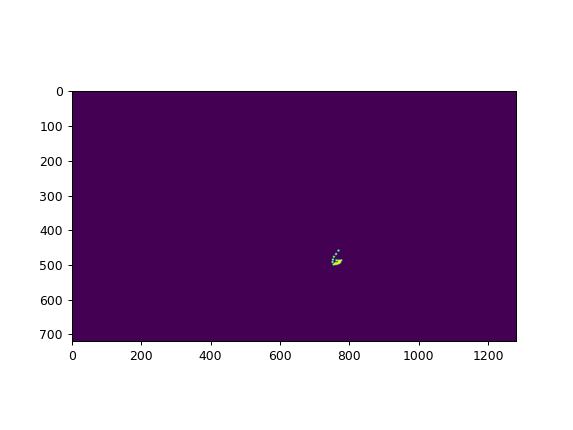

In [55]:
# create grayscale image with white circle (255) on black background (0)
mask = np.zeros(shape = frame.shape[:2],dtype = np.uint8)
for point in left_hand:
    cv2.circle(mask,(int(point[0]),int(point[1])),3,255,-1)
# for point in right_hand:
#     cv2.circle(mask,(int(point[0]),int(point[1])),3,255,-1)
# mask_draw = ImageDraw.Draw(mask)
# width, height = img_cropped.size
# mask_draw.ellipse((0, 0, width, height), fill=255)
plt.imshow(mask)

In [56]:


plt.imshow(mask)

In [57]:
points = np.ravel_multi_index((coordy,coordx),frame.shape[:2])

color = clean_df.loc[index,'cam_right_color']
depth = clean_df.loc[index,'cam_right_depth']
pcd = load_whole_point_cloud(color,depth,'realsense_right')

In [58]:
hand = pcd.select_by_index(points)
hand.remove_non_finite_points()
cl, ind = hand.remove_radius_outlier(nb_points=30, radius=0.05)

In [67]:
%%time



CPU times: user 18.7 ms, sys: 0 ns, total: 18.7 ms
Wall time: 3.11 ms


In [68]:
o3d.visualization.draw_geometries([actual_hand,flipped_hand])

In [ ]:
help(o3d.visualization.draw_geometries)

In [ ]:
pcd

In [ ]:
frame.shape[0]*frame.shape[1]